# Outlier detection

## Choose and generate dataset

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from matplotlib.colors import Normalize

from sklearn import datasets, metrics, preprocessing, svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
#A changer selon l'ordinateur
pathtodata='./Data_OK/'

In [3]:
datasetsnames=["generated","creditcard","http","kdd10","kdd","smtp"]

#Changer le numéro pour choisir le nom
datasetname=datasetsnames[1]

- N.B. : creditcard ne fonctionne pas pour LocalOutlierFactor
- kdd est trop gros (fonctionne pour 40% pour 16 GB RAM), utiliser seulement kdd10
- smtp ne présente que 3 outliers, inintéressant

In [4]:
def column_generator(nbvar):
    SAcolumns=[]
    for i in range(1,nbvar+1):
        SAcolumns.append("var_{}".format(i))
    SAcolumns.append("label")
    return SAcolumns

def data_set(dataname):
    if dataname=="generated":
        return pd.read_csv(pathtodata+'Data_2.csv', low_memory=False)
    elif dataname=="creditcard":
        return pd.read_csv(pathtodata+'creditcard_2.csv', low_memory=False)
    elif dataname=="smtp" or dataname=="http" or dataname=="SA" or dataname=="SF":
        dataset=datasets.fetch_kddcup99(subset=dataname, data_home=None, shuffle=False, random_state=None, percent10=True, download_if_missing=True)
        data=dataset['data']
        target=dataset['target']
        data=np.append(data,np.array(target).reshape(-1,1),axis=1)
        if dataname=="smtp" or dataname=="http":
            return pd.DataFrame(data=data,columns=column_generator(3))
        elif dataname=="SF":
            return pd.DataFrame(data=data,columns=column_generator(4))
        elif dataname=="SA":
            return pd.DataFrame(data=data,columns=column_generator(41))
    elif dataname=="kdd10":
        return pd.read_csv(pathtodata+'kddcup.data_10_percent_corrected.csv', header=None, low_memory=False)
    elif dataname=="kdd":
        return pd.read_csv(pathtodata+'kddcup.data.corrected.csv', header=None, low_memory=False)

In [5]:
data=data_set(datasetname)

## Making our data one-class

1) Convert the outliers into class 1 (normal) and class -1 (outlier) <br>
2) Copy outlier labels to evaluate performance later <br>
3) Compute proportion of outliers <br>
4) Drop label and useless columns from the dataframe, to do unsupervised training with unlabelled data

In [6]:
all_label_columns = {"generated": 'label',
                      "creditcard": 'label',
                      "kdd10": 41,
                      "kdd": 41,
                      "smtp": 'label', 
                      "http": 'label',
                      "SA": 'label',
                      "SF": 'label'}
all_normal_labels = {"generated": "b'0'",
                       "creditcard": 0,
                       "kdd10": "normal.",
                       "kdd": "normal.", 
                       "smtp": b'normal.', 
                       "http": b'normal.', 
                       "SA": b'normal.', 
                       "SF": b'normal.'}

label_column = all_label_columns[datasetname]
normal_label = all_normal_labels[datasetname]

normal_value = -1
outlier_value = 1

data.loc[data[label_column] != normal_label, "outlier"] = outlier_value
data.loc[data[label_column] == normal_label, "outlier"] = normal_value
if datasetname=="kdd10" or datasetname=="kdd":
    data.loc[data[label_column] == "smurf.", "outlier"] = normal_value 
    data.loc[data[label_column] == "neptune.", "outlier"] = normal_value 

target = data['outlier']

outliers = target[target == outlier_value]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", outliers.shape[0]/target.shape[0])

all_useless_columns = {"generated": ["label", "outlier"],
                     "creditcard": ["Time", "label", "outlier"],
                     "kdd10": [41, 1, 2, 3, "outlier"],
                     "kdd": [41, 1, 2, 3, "outlier"],  
                     "smtp": ["label", "outlier"], 
                     "http": ["label", "outlier"], 
                     "SA": ["label", "var_2", "var_3", "var_4", "outlier"], 
                     "SF": ["label", "var_2", "outlier"]
                    }

useless_columns = all_useless_columns[datasetname]
data.drop(useless_columns, axis=1, inplace=True)

print(data.shape) 

outliers.shape (492,)
outlier fraction 0.001727485630620034
(284807, 29)


## Normalize data

In [7]:
def normalized_data(data, type_normalization):
    if type_normalization=="normalizer":
        return normalize(data,axis=0)
    elif type_normalization=="minmaxscaler":
        min_max_scaler = preprocessing.MinMaxScaler()
        return min_max_scaler.fit_transform(data)
    elif type_normalization=="standardscaler":
        standard_scaler = preprocessing.StandardScaler()
        return standard_scaler.fit_transform(data)
    elif type_normalization==False:
        return data

In [8]:
normalization_types = ["normalizer","minmaxscaler","standardscaler",False]

#Choisir la normalisation minmaxscaler pour Autoencoder
chosen_normalization = normalization_types[2] 

In [9]:
data = normalized_data(data, chosen_normalization)

## Shuffling and splitting data into training and test sets

In [10]:
def data_split(data,target,ratio):
    if 0<ratio and ratio<1:
        X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle = True, train_size = ratio)
    elif ratio==1:
        X_train, X_test, y_train, y_test = data, data, target, target
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = data_split(data, target, 1)

In [12]:
X_train.shape

(284807, 29)

## Profit function

In [13]:
def profit(y_true,y_pred,verbose=True):
    true_positive = np.sum(np.where(np.logical_and(y_true==1,y_pred==1),1,0))
    false_positive = np.sum(np.where(np.logical_and(y_true==-1,y_pred==1),1,0))
    positive = np.sum(np.where(y_true==1,1,0))
    negative = len(y_true)-positive
    if verbose:
        print("True Positive Rate: ", true_positive/positive)
        print("Number of False Positive: ", false_positive)
        print("False Positive Rate: ", false_positive/negative)
        print()
    return 160*(2*true_positive/positive-1) - 160*false_positive/negative

## Combination of different classifiers

### Isolation Forest

In [14]:
data_if = normalized_data(data, False)

X_train, X_test, y_train, y_test = train_test_split(data_if, target,
                                                    stratify=target, 
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
clf_if = IsolationForest(contamination=0.099)
clf_if.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.099, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [16]:
y_if_score_train = -clf_if.decision_function(X_train)

In [17]:
y_if_score_test = -clf_if.decision_function(X_test)

### Autoencoder

In [18]:
data_ae = normalized_data(data,"minmaxscaler")
X_train, X_test, y_train, y_test = train_test_split(data_ae, target,
                                                    stratify=target, 
                                                    test_size=0.2,
                                                   random_state=42)

In [19]:
encoding_dim = int(0.8*data_ae.shape[1])
input = Input(shape=(data_ae.shape[1],)) 
encoded_1 = Dense(encoding_dim, activation='relu')(input)
decoded_2 = Dense(data_ae.shape[1], activation='sigmoid')(encoded_1)
autoencoder = Model(inputs=input, outputs=decoded_2)
encoder = Model(inputs=input, outputs=encoded_1)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
autoencoder.fit(X_train, X_train,epochs=100,batch_size=data_ae.shape[1],shuffle=True,verbose=1)

Epoch 1/100
227845/227845 [==============================] - 9s 39us/step - loss: 0.5914
Epoch 2/100
227845/227845 [==============================] - 9s 41us/step - loss: 0.5895
Epoch 3/100
227845/227845 [==============================] - 10s 42us/step - loss: 0.5888
Epoch 4/100
227845/227845 [==============================] - 11s 47us/step - loss: 0.5885
Epoch 5/100
227845/227845 [==============================] - 12s 51us/step - loss: 0.5884
Epoch 6/100
227845/227845 [==============================] - 11s 50us/step - loss: 0.5883
Epoch 7/100
227845/227845 [==============================] - 11s 50us/step - loss: 0.5883
Epoch 8/100
227845/227845 [==============================] - 12s 52us/step - loss: 0.5882
Epoch 9/100
227845/227845 [==============================] - 10s 46us/step - loss: 0.5881
Epoch 10/100
227845/227845 [==============================] - 10s 43us/step - loss: 0.5881
Epoch 11/100
227845/227845 [==============================] - 10s 46us/step - loss: 0.5880
Epoch 12/1

227845/227845 [==============================] - 9s 38us/step - loss: 0.5877
Epoch 92/100
227845/227845 [==============================] - 9s 39us/step - loss: 0.5877
Epoch 93/100
227845/227845 [==============================] - 10s 44us/step - loss: 0.5877
Epoch 94/100
227845/227845 [==============================] - 11s 46us/step - loss: 0.5877
Epoch 95/100
227845/227845 [==============================] - 10s 43us/step - loss: 0.5877
Epoch 96/100
227845/227845 [==============================] - 12s 51us/step - loss: 0.5877
Epoch 97/100
227845/227845 [==============================] - 12s 53us/step - loss: 0.5877
Epoch 98/100
227845/227845 [==============================] - 10s 45us/step - loss: 0.5877
Epoch 99/100
227845/227845 [==============================] - 11s 49us/step - loss: 0.5877
Epoch 100/100
227845/227845 [==============================] - 11s 50us/step - loss: 0.5877


In [21]:
decoded = autoencoder.predict(X_test)
dist = np.zeros(X_test.shape[0])

In [22]:
for i, x in enumerate(X_test):
    dist[i] = np.linalg.norm(x-decoded[i], ord = np.inf)
y_ae_score_test = dist
decoded = autoencoder.predict(X_train)
dist = np.zeros(X_train.shape[0])

In [23]:
for i, x in enumerate(X_train):
    dist[i] = np.linalg.norm(x-decoded[i], ord = np.inf)
y_ae_score_train = dist

### One Class SVM

In [24]:
nu = outliers.shape[0] / target.shape[0]  
data = pd.DataFrame(data)
data_svm = data.values

In [25]:
index_inliers = np.where(target == normal_value)
index_outliers = np.where(target != normal_value)
data_inliers = data_svm[index_inliers]
data_outliers = data_svm[index_outliers]

scaler = preprocessing.StandardScaler().fit(data_inliers) 
data_inliers = scaler.transform(data_inliers)  
data_outliers = scaler.transform(data_outliers)
data_svm = scaler.transform(data_svm)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_svm, target,
                                                    stratify=target, 
                                                    test_size=0.2,
                                                   random_state=42)

In [27]:
clf = svm.OneClassSVM(nu=nu,kernel='rbf',gamma=10**-1)
clf.fit(data_inliers)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.001727485630620034, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [28]:
y_svm_score_train = -clf.decision_function(X_train)

In [29]:
y_svm_score_test = -clf.decision_function(X_test)

### Elliptic Enveloppe

In [30]:
data_ee = normalized_data(data,False)
X_train, X_test, y_train, y_test = train_test_split(data_ee, target,
                                                    stratify=target, 
                                                    test_size=0.2,
                                                   random_state=42)

In [31]:
clf_ee = EllipticEnvelope(contamination=0.0688888888889)
clf_ee.fit(X_train)

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.922977212739454 > -190.332745735030358)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-189.925722881302590 > -190.020360819067434)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-162.534801097721754 > -164.095116373679616)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-232.076772673687969 > -238.373419524948531)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-207.879445

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-214.950844440808538 > -215.791275333322062)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.545937753588873 > -235.376858400593562)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-170.291115432113685 > -265.803921451183328)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-175.968133269981166 > -176.822621647481753)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-188.006719

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-145.774379818595094 > -145.868064692138432)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.793251246731160 > -235.938582137951641)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-235.607040354086394 > -242.690140046344453)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-238.638611493313817 > -239.522112068207605)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.587194

/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-203.826260179963100 > -266.781550847740846)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-202.595850136806149 > -234.622883609133737)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-179.339469545817394 > -268.796618961630770)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-150.617722673012963 > -151.672347983813324)
  % (det, previous_det), RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-205.419677

EllipticEnvelope(assume_centered=False, contamination=0.0688888888889,
         random_state=None, store_precision=True, support_fraction=None)

In [32]:
y_ee_score_train = -clf_ee.decision_function(X_train)

In [33]:
y_ee_score_test = -clf_ee.decision_function(X_test)

### Rank averaging

In [34]:
def compute_rank(scores):
    rank = [0] * len(scores)
    for i, x in enumerate(sorted(range(len(scores)), key=lambda y: scores[y])):
        rank[x] = i
    return rank

In [35]:
rank_if_train = np.asarray(compute_rank(y_if_score_train))
rank_ae_train = np.asarray(compute_rank(y_ae_score_train))
rank_svm_train = np.asarray(compute_rank(y_svm_score_train))
rank_ee_train = np.asarray(compute_rank(y_ee_score_train))

In [36]:
rank_if_test = np.asarray(compute_rank(y_if_score_test))
rank_ae_test = np.asarray(compute_rank(y_ae_score_test))
rank_svm_test = np.asarray(compute_rank(y_svm_score_test))
rank_ee_test = np.asarray(compute_rank(y_ee_score_test))

In [37]:
mean_rank_train = 0.25*(rank_if_train+rank_ae_train+rank_svm_train+rank_ee_train)
mean_rank_test = 0.25*(rank_if_test+rank_ae_test+rank_svm_test+rank_ee_test)
mean_rank_rank_train = compute_rank(mean_rank_train)
mean_rank_rank_test = compute_rank(mean_rank_test)

In [38]:
contamination = np.linspace(0.8,0.9,31)
profit_train = []
profit_test = []
for c in contamination:
    print("Contamination = ", c)
    y_pred_train = np.where(mean_rank_rank_train >= c*len(mean_rank_rank_train),1,-1)
    y_pred_test = np.where(mean_rank_rank_test >= c*len(mean_rank_rank_test ),1,-1)
    profit_train.append(profit(y_train,y_pred_train))
    profit_test.append(profit(y_test,y_pred_test))

Contamination =  0.8
True Positive Rate:  0.9137055837563451
Number of False Positive:  45209
False Positive Rate:  0.19876368976175088

True Positive Rate:  0.9387755102040817
Number of False Positive:  11300
False Positive Rate:  0.19871975239167136

Contamination =  0.8033333333333333
True Positive Rate:  0.9111675126903553
Number of False Positive:  44450
False Positive Rate:  0.19542670729080108

True Positive Rate:  0.9387755102040817
Number of False Positive:  11110
False Positive Rate:  0.19537844682048397

Contamination =  0.8066666666666668
True Positive Rate:  0.9086294416243654
Number of False Positive:  43692
False Positive Rate:  0.19209412137119644

True Positive Rate:  0.9387755102040817
Number of False Positive:  10920
False Positive Rate:  0.19203714124929658

Contamination =  0.81
True Positive Rate:  0.9086294416243654
Number of False Positive:  42932
False Positive Rate:  0.18875274234890152

True Positive Rate:  0.9285714285714286
Number of False Positive:  10731


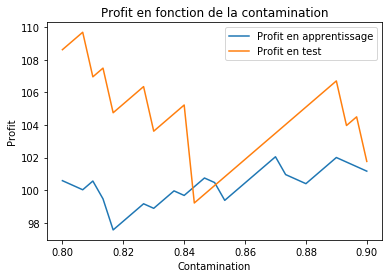

In [39]:
plt.title("Profit en fonction de la contamination")
plt.xlabel("Contamination")
plt.ylabel("Profit")
plt.plot(contamination,profit_train,label="Profit en apprentissage")
plt.plot(contamination,profit_test,label="Profit en test")
plt.legend()
plt.savefig("average_ranking.png")
plt.show()

### Bagging

In [40]:
probas_train = np.hstack((np.asarray(y_if_score_train).reshape(-1,1),np.asarray(y_ae_score_train).reshape(-1,1)))
probas_train = np.hstack((probas_train,np.asarray(y_svm_score_train).reshape(-1,1)))
probas_train = np.hstack((probas_train,np.asarray(y_ee_score_train).reshape(-1,1)))

In [41]:
probas_test = np.hstack((np.asarray(y_if_score_test).reshape(-1,1),np.asarray(y_ae_score_test).reshape(-1,1)))
probas_test = np.hstack((probas_test,np.asarray(y_svm_score_test).reshape(-1,1)))
probas_test = np.hstack((probas_test,np.asarray(y_ee_score_test).reshape(-1,1)))

In [42]:
clf_logi = LogisticRegression()
clf_logi.fit(probas_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
y_probas_train = clf_logi.predict_proba(probas_train)[:,1]

In [44]:
y_probas_test = clf_logi.predict_proba(probas_test)[:,1]

In [45]:
contamination = np.linspace(0.001,0.01,100)
profit_train = []
profit_test = []
for c in contamination:
    print("Contamination = ", c)
    y_pred_train = np.where(y_probas_train >= c,1,-1)
    y_pred_test = np.where(y_probas_test >= c,1,-1)
    profit_train.append(profit(y_train,y_pred_train))
    profit_test.append(profit(y_test,y_pred_test))

Contamination =  0.001
True Positive Rate:  0.9213197969543148
Number of False Positive:  49526
False Positive Rate:  0.217743601918655

True Positive Rate:  0.9387755102040817
Number of False Positive:  12441
False Positive Rate:  0.21878517163759145

Contamination =  0.001090909090909091
True Positive Rate:  0.9213197969543148
Number of False Positive:  46527
False Positive Rate:  0.20455834443462548

True Positive Rate:  0.9387755102040817
Number of False Positive:  11688
False Positive Rate:  0.20554305008441193

Contamination =  0.0011818181818181819
True Positive Rate:  0.9187817258883249
Number of False Positive:  43869
False Positive Rate:  0.19287231095928353

True Positive Rate:  0.9387755102040817
Number of False Positive:  10974
False Positive Rate:  0.19298677546426563

Contamination =  0.0012727272727272728
True Positive Rate:  0.916243654822335
Number of False Positive:  41560
False Positive Rate:  0.18272067390339017

True Positive Rate:  0.9387755102040817
Number of Fa

True Positive Rate:  0.9081632653061225
Number of False Positive:  4472
False Positive Rate:  0.07864378165447383

Contamination =  0.004090909090909091
True Positive Rate:  0.8908629441624365
Number of False Positive:  17197
False Positive Rate:  0.07560749348211263

True Positive Rate:  0.9081632653061225
Number of False Positive:  4390
False Positive Rate:  0.07720174451322454

Contamination =  0.004181818181818182
True Positive Rate:  0.8908629441624365
Number of False Positive:  16918
False Positive Rate:  0.07438085565682279

True Positive Rate:  0.8877551020408163
Number of False Positive:  4323
False Positive Rate:  0.07602349465391109

Contamination =  0.0042727272727272735
True Positive Rate:  0.8908629441624365
Number of False Positive:  16609
False Positive Rate:  0.07302232129117919

True Positive Rate:  0.8877551020408163
Number of False Positive:  4264
False Positive Rate:  0.07498593134496342

Contamination =  0.004363636363636364
True Positive Rate:  0.8908629441624365

True Positive Rate:  0.8604060913705583
Number of False Positive:  8997
False Positive Rate:  0.039555772452088585

True Positive Rate:  0.8673469387755102
Number of False Positive:  2343
False Positive Rate:  0.04120357343837929

Contamination =  0.008
True Positive Rate:  0.8604060913705583
Number of False Positive:  8872
False Positive Rate:  0.03900620353394797

True Positive Rate:  0.8673469387755102
Number of False Positive:  2313
False Positive Rate:  0.040675998874507596

Contamination =  0.008090909090909091
True Positive Rate:  0.8604060913705583
Number of False Positive:  8747
False Positive Rate:  0.03845663461580736

True Positive Rate:  0.8673469387755102
Number of False Positive:  2288
False Positive Rate:  0.04023635340461452

Contamination =  0.008181818181818182
True Positive Rate:  0.8604060913705583
Number of False Positive:  8623
False Positive Rate:  0.037911462249011874

True Positive Rate:  0.8673469387755102
Number of False Positive:  2266
False Positive Rate: 

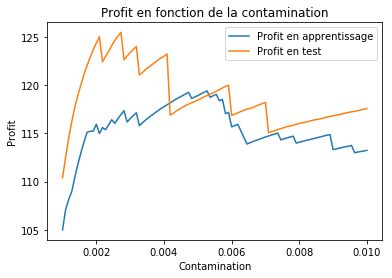

In [46]:
plt.title("Profit en fonction de la contamination")
plt.xlabel("Contamination")
plt.ylabel("Profit")
plt.plot(contamination,profit_train+5*np.ones(len(profit_train)),label="Profit en apprentissage")
plt.plot(contamination,profit_test+5*np.ones(len(profit_test)),label="Profit en test")
plt.legend()
plt.savefig("baggling.png")
plt.show()